# SVM

## 0. Setup: import packages and define custom functions

In [1]:
# For loading data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# For training and tuning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_predict, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict
from scipy.stats import uniform
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, Normalizer, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import time

# For saving, loading model
from joblib import dump, load

In [2]:
# For loading and preprocessing data
def prepare_data(csv):
    """
    Read csv and returns: 
    X_train: full no-oversampled features, 
    y_train: no-oversampled labels, 
    X_train_os: full oversampled features, 
    y_train_os: oversampled features, 
    X_train_os_sub: selected, oversampled, standardized features, 
    y_train_os_sub: oversampled features, same as y_train_os, just for easier use.
    """
    # 1.Read data
    train_df = pd.read_csv(csv)

    # 2. Split X, y
    X = train_df.iloc[:, :12]
    y_train = train_df.iloc[:, 12]

    # 3. Perform feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X)
    
    # 4. SMOTE
    smote = SMOTE(sampling_strategy='minority', random_state=66)
    X_train_os, y_train_os = smote.fit_resample(X, y_train)
    scaler = StandardScaler()
    X_train_os = scaler.fit_transform(X_train_os)
    
    # 5. Feature Selection
    X_train_os_sub, y_train_os_sub = smote.fit_resample(train_df.iloc[:, [0,1,2,3,4,6,7,10,11]], 
                                                train_df.iloc[:, 12])
    X_train_os_sub = scaler.fit_transform(X_train_os_sub)
    
    return X_train, y_train, X_train_os, y_train_os, X_train_os_sub, y_train_os_sub

# ref: https://www.datacamp.com/blog/classification-machine-learning

In [3]:
# For fitting and evaluating SVM
def fit_evaluate_svm(X, y):
    """Fit and evaluate baseline model."""
    
    # 1. Creat model
    svm_baseline = SVC(random_state=66)

    # 2. Fit and evaluate baseline model
    T0_base = time.time()
    y_pred_base = cross_val_predict(svm_baseline, X, y, cv=5)
    T1_base = time.time()
    training_time_base = T1_base - T0_base
    acc = accuracy_score(y, y_pred_base)

    # 3. Display metrics
    print("Evaluation with cross-validation")
    print("Baseline Classification Report:")
    print(classification_report(y, y_pred_base))
    print(f"Baseline Training time: {training_time_base:.4f}")

    cm = confusion_matrix(y, y_pred_base)
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('CM for baseline SVM')
    plt.show()
    
    return svm_baseline, acc,training_time_base

In [12]:
# For performing RandomSearch
def tune_SVM(X, y, lower_C, upper_C, lower_gamma, upper_gamma):
    """
    Model-level tuning.
    Uses random search. Hyperparameters being tuned include: C, gamma, kernel.
    X: features,e.g. X_train_V2
    y: labels, e.g. y_train_V2
    returns best_estimator, best_score, training_time.
    """
    
    # Define hyperparameter grid
    param_dist = {
        'C': uniform(lower_C, upper_C),  
        'gamma': uniform(lower_gamma, upper_gamma),
        #'kernel': ['rbf', 'sigmoid'] #sigmoid generally performs worse, discard
    }

    # Create SVC model
    svc = SVC()

    # Create RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=svc,
        param_distributions=param_dist,
        n_iter=15,  
        cv=5,  
        scoring='accuracy',  
        #random_state=66,
        verbose=0,
        n_jobs=-1)

    # Perform random search
    T0 = time.time()
    random_search.fit(X, y)
    T1 = time.time()
    training_time = T1-T0
    
    # Check the best model and the best params
    best_estimator = random_search.best_estimator_
    best_params = random_search.best_params_
    best_score = random_search.best_score_

    print(f"Best Parameters: {best_params}")
    print(f"Best Acc Score: {best_score:.4f}")
    print(f"Training time: {training_time:.4f}")
    
    #Evaluate best model
    y_pred_cv = cross_val_predict(best_estimator, X, y, cv=5)
    print("\nClassification Report:")
    print(classification_report(y, y_pred_cv))

    # Plot confusion matrix
    cm = confusion_matrix(y, y_pred_cv)
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('CM')
    plt.show()

    return best_estimator, best_score, training_time

In [5]:
# For testing final model
def final_test(csv, model):
    """Test model on unseen test set."""
    # 1. Read and prepare unseen test set
    unseen_df = pd.read_csv(csv)
    X_unseen = unseen_df.iloc[:, :12]
    y_unseen = unseen_df.iloc[:, 12]

    scaler = StandardScaler()
    X_unseen = scaler.fit_transform(X_unseen)

    # 2. Load model
    model = load(model)
    
    # 3. Predict and evaluate on unseen TEST set
    y_preds_test = model.predict(X_unseen)
    cm_test = confusion_matrix(y_unseen, y_preds_test)

    # 4. Display test results
    print("Classification Report on Test Set")
    print(classification_report(y_unseen, y_preds_test))
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('CM on test set')
    plt.show()

## 1. Prepare dataset

In [3]:
# read, oversample and feature selection on dataset
X_train, y_train, X_train_os, y_train_os, X_train_os_sub, y_train_os_sub = prepare_data('train.csv')

# Check datasets shape
print(X_train.shape, y_train.shape, 
      X_train_os.shape, y_train_os.shape, 
      X_train_os_sub.shape, y_train_os_sub.shape)

(5197, 12) (5197,) (6445, 12) (6445,) (6445, 9) (6445,)


In [7]:
# Define lists to store intermediate models, performance and training_time
model_names = []
models = []
accs = []
training_times = []

## 2. Training

### 2.1 Fit baseline model

Evaluation with cross-validation
Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.68      0.69      1907
           1       0.56      0.68      0.61      2269
           2       0.64      0.35      0.46      1021

    accuracy                           0.62      5197
   macro avg       0.63      0.57      0.59      5197
weighted avg       0.62      0.62      0.61      5197

Baseline Training time: 7.2536


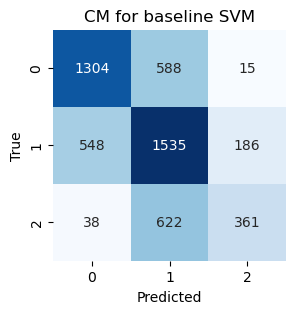

In [8]:
# Fit and evaluate baseline SVM
svm_baseline, acc_base, training_time_base = fit_evaluate_svm(X_train, y_train)

model_names.append('svm_baseline')
models.append(svm_baseline)
accs.append(acc_base)
training_times.append(training_time_base)

### 2.2. Experiments: Try SMOTE, feature selection
as data-level tuning

#### 2.2.1. Try SMOTE oversampling on top of baseline

Evaluation with cross-validation
Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1907
           1       0.53      0.44      0.48      2269
           2       0.68      0.78      0.73      2269

    accuracy                           0.63      6445
   macro avg       0.63      0.64      0.63      6445
weighted avg       0.63      0.63      0.63      6445

Baseline Training time: 10.3805


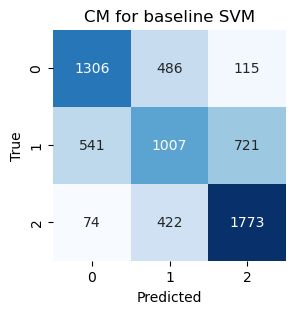

In [9]:
# Fit and evaluate SVM with oversampled training set
svm_SMOTE, acc_SMOTE, training_time_SMOTE =fit_evaluate_svm(X_train_os, y_train_os)

model_names.append('svm_SMOTE')
models.append(svm_SMOTE)
accs.append(acc_SMOTE)
training_times.append(training_time_SMOTE)

#### 2.2.2. Try Feature selection on top of SMOTE

Evaluation with cross-validation
Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      1907
           1       0.50      0.41      0.45      2269
           2       0.64      0.77      0.70      2269

    accuracy                           0.61      6445
   macro avg       0.60      0.61      0.60      6445
weighted avg       0.60      0.61      0.60      6445

Baseline Training time: 10.1010


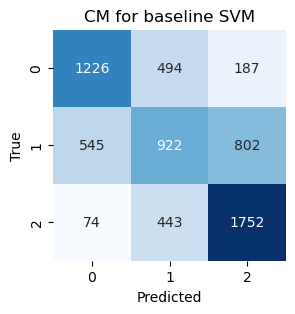

In [10]:
# Fit and evaluate SVM with oversampled and selected features training set
svm_sub, acc_sub, training_time_sub =fit_evaluate_svm(X_train_os_sub, y_train_os_sub)

model_names.append('svm_sub')
models.append(svm_sub)
accs.append(acc_sub)
training_times.append(training_time_sub)

## 3. Hyperparameter Tuning and Model Selection
* Based on experiments, I decided to use oversampled training set with full features. 
* For hyperparameter tuning, selected hyperparameters include "C", kernel, gamma.
* Search method: random search.
* Validation: 5-fold cross-validation.

### 3.1. Try and iterate hyperparameters with RamdomSearchCV

Best Parameters: {'C': 1.015847611445441, 'gamma': 0.9192673847220937}
Best Acc Score: 0.7173
Training time: 45.1699

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.66      0.68      1907
           1       0.63      0.63      0.63      2269
           2       0.82      0.85      0.83      2269

    accuracy                           0.72      6445
   macro avg       0.71      0.71      0.71      6445
weighted avg       0.72      0.72      0.72      6445



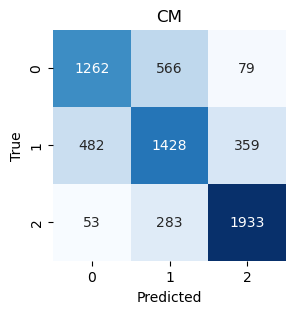

In [13]:
# Perform random search - round 1 - start from small C and gamma

lower_C=0.1
upper_C=1
lower_gamma=0.1 
upper_gamma=1
best_model_1, best_score_1, training_time_1 = tune_SVM(X_train_os, y_train_os, 
                                                       lower_C, upper_C,
                                                       lower_gamma, upper_gamma)

model_names.append('best_model_1')
models.append(best_model_1)
accs.append(best_score_1)
training_times.append(training_time_1)

Best Parameters: {'C': 35568.38722168836, 'gamma': 0.9611793316058178}
Best Acc Score: 0.7285
Training time: 95.7993

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.67      0.68      1907
           1       0.64      0.66      0.65      2269
           2       0.85      0.85      0.85      2269

    accuracy                           0.73      6445
   macro avg       0.73      0.73      0.73      6445
weighted avg       0.73      0.73      0.73      6445



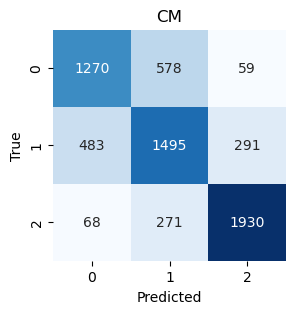

In [14]:
# Random search - round 2: try small gamma and large C
# The idea of small gamma and large C: https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html 

lower_C=50
upper_C=50000
lower_gamma=0.1 
upper_gamma=1

best_model_2, best_score_2, training_time_2 = tune_SVM(X_train_os, y_train_os, 
                                                       lower_C, upper_C,
                                                       lower_gamma, upper_gamma)

model_names.append('best_model_2')
models.append(best_model_2)
accs.append(best_score_2)
training_times.append(training_time_2)

Best Parameters: {'C': 4737.804615170226, 'gamma': 1.058494725632029}
Best Acc Score: 0.7292
Training time: 103.8188

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.65      0.68      1907
           1       0.63      0.67      0.65      2269
           2       0.85      0.85      0.85      2269

    accuracy                           0.73      6445
   macro avg       0.73      0.73      0.73      6445
weighted avg       0.73      0.73      0.73      6445



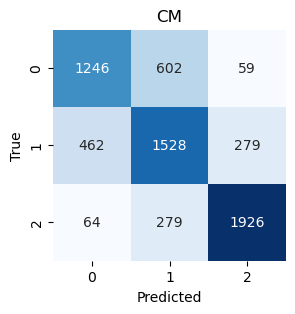

In [15]:
# Random search - round 3, try decreasing C because large C is computational expensive
lower_C=50
upper_C=5000
lower_gamma=0.1 
upper_gamma=1

best_model_3, best_score_3, training_time_3 = tune_SVM(X_train_os, y_train_os, 
                                                       lower_C, upper_C,
                                                       lower_gamma, upper_gamma)

model_names.append('best_model_3')
models.append(best_model_3)
accs.append(best_score_3)
training_times.append(training_time_3)

# The idea of small gamma and large C: https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html 

Best Parameters: {'C': 45.143245738892865, 'gamma': 0.7768489698271543}
Best Acc Score: 0.7297
Training time: 57.9959

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.68      0.69      1907
           1       0.65      0.64      0.64      2269
           2       0.84      0.86      0.85      2269

    accuracy                           0.73      6445
   macro avg       0.73      0.73      0.73      6445
weighted avg       0.73      0.73      0.73      6445



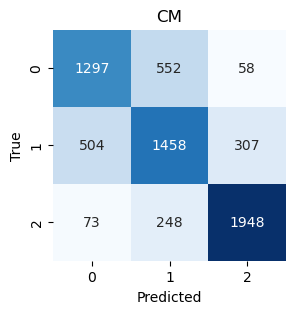

In [16]:
# Random search - round 4, further decreasing C
lower_C=2
upper_C=100
lower_gamma=0.1 
upper_gamma=1

best_model_4, best_score_4, training_time_4 = tune_SVM(X_train_os, y_train_os, 
                                                       lower_C, upper_C,
                                                       lower_gamma, upper_gamma)

model_names.append('best_model_4')
models.append(best_model_4)
accs.append(best_score_4)
training_times.append(training_time_4)

# the choice of small gamma and large C - ref: https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

Best Parameters: {'C': 20.184802700387333, 'gamma': 0.6156592167669666}
Best Acc Score: 0.7306
Training time: 51.8797

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.70      0.70      1907
           1       0.66      0.62      0.64      2269
           2       0.83      0.86      0.85      2269

    accuracy                           0.73      6445
   macro avg       0.73      0.73      0.73      6445
weighted avg       0.73      0.73      0.73      6445



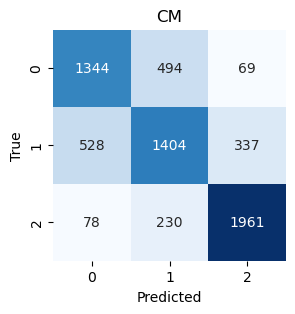

In [17]:
# Random search - round 5, further decreasing C
lower_C=1
upper_C=50
lower_gamma=0.1 
upper_gamma=1

best_model_5, best_score_5, training_time_5 = tune_SVM(X_train_os, y_train_os, 
                                                       lower_C, upper_C,
                                                       lower_gamma, upper_gamma)

model_names.append('best_model_5')
models.append(best_model_5)
accs.append(best_score_5)
training_times.append(training_time_5)

# the choice of small gamma and large C - ref: https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

Best Parameters: {'C': 3.5176637250888256, 'gamma': 0.7868720667965234}
Best Acc Score: 0.7314
Training time: 50.7604

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.69      1907
           1       0.65      0.63      0.64      2269
           2       0.83      0.87      0.85      2269

    accuracy                           0.73      6445
   macro avg       0.73      0.73      0.73      6445
weighted avg       0.73      0.73      0.73      6445



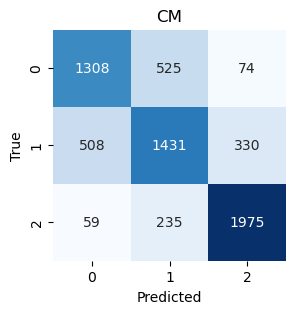

In [18]:
# Perform random search - round 6, try decreasing C

# ref: https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
# "Finally, for some values of gamma we get equally performing models when C becomes very large."
# "This suggests that the set of support vectors does not change anymore. The radius of the RBF kernel alone acts as a good structural regularizer. "
# "Increasing C further doesn’t help, likely because there are no more training points in violation (inside the margin or wrongly classified), or at least no better solution can be found." 
# "Scores being equal, it may make sense to use the smaller C values, since very high C values typically increase fitting time."
# So just keep it simple..

lower_C=1
upper_C=20
lower_gamma=0.1 
upper_gamma=1

best_model_6, best_score_6, training_time_6 = tune_SVM(X_train_os, y_train_os, 
                                                       lower_C, upper_C,
                                                       lower_gamma, upper_gamma)

model_names.append('best_model_6')
models.append(best_model_6)
accs.append(best_score_6)
training_times.append(training_time_6)



### 3.2. Compare results on different tuning implementation

In [19]:
# Compare results from previous runs.
summary = {
    'Model Name': model_names,
    'Model': models,
    'Val_acc': accs,
    'Training Time': training_times
}

# Create a DataFrame from the dictionary
model_summary = pd.DataFrame(summary)
model_summary.to_csv("model_summary_SVM.csv", index=False)
model_summary

,Model Name,Model,Val_acc,Training Time
0,svm_baseline,SVC(random_state=66),0.615740,7.253554
1,svm_SMOTE,SVC(random_state=66),0.633980,10.380503
2,svm_sub,SVC(random_state=66),0.605120,10.100967
3,best_model_1,"SVC(C=1.015847611445441, gamma=0.9192673847220...",0.717300,45.169882
4,best_model_2,"SVC(C=35568.38722168836, gamma=0.9611793316058...",0.728472,95.799342
5,best_model_3,"SVC(C=4737.804615170226, gamma=1.058494725632029)",0.729247,103.818757
6,best_model_4,"SVC(C=45.143245738892865, gamma=0.776848969827...",0.729713,57.995888
7,best_model_5,"SVC(C=20.184802700387333, gamma=0.615659216766...",0.730644,51.879720
8,best_model_6,"SVC(C=3.5176637250888256, gamma=0.786872066796...",0.731420,50.760412


### 3.3. Decide and save best model

In [20]:
# Exactact the best final model
best_index = summary['Val_acc'].index(max(summary['Val_acc']))
best_model_final = summary['Model'][best_index]

In [21]:
# Fit the best model on the training set again and calculate the training time
t0=time.time()
best_model_final.fit(X_train_os, y_train_os)
t1=time.time()
training_time = t1-t0
training_time

3.074256181716919

In [25]:
# Save best SVM model
dump(best_model_final, 'best_SVM.joblib')

['best_SVM.joblib']

## 4. Test the best model on unseen test set

Classification Report on Test Set
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       477
           1       0.68      0.67      0.68       567
           2       0.63      0.71      0.67       256

    accuracy                           0.70      1300
   macro avg       0.70      0.70      0.70      1300
weighted avg       0.70      0.70      0.70      1300



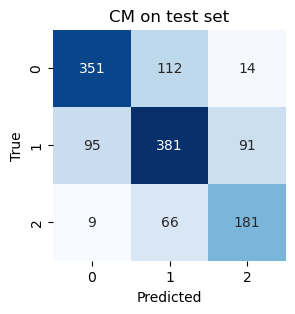

In [26]:
# Test best model on unseen test set
final_test('unseen.csv', 'best_SVM.joblib')

## Appendix - other experiments and implementations

In [11]:
# Try different kernels
def try_kernel_svm(X, y, kernel):
    """Fit and evaluate baseline model."""
    
    # 1. Creat model
    svm_baseline = SVC(random_state=66, kernel=kernel)

    # 2. Fit and evaluate baseline model
    T0_base = time.time()
    y_pred_base = cross_val_predict(svm_baseline, X, y, cv=5)
    T1_base = time.time()
    training_time_base = T1_base - T0_base
    acc = accuracy_score(y, y_pred_base)

    # 3. Display metrics
    print(f"Acc: {acc:.4f}")
    print("Evaluation with cross-validation")
    print("Baseline Classification Report:")
    print(classification_report(y, y_pred_base))
    print(f"Training time: {training_time_base:.4f}")

    cm = confusion_matrix(y, y_pred_base)
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('CM for baseline SVM')
    plt.show()
    
    return svm_baseline, acc,training_time_base

In [5]:
# for tring normalization or polynomial scaling

def try_scaling_svm(csv, scaling):
    """
    Change scaling from standardization to a custom one.
    Use SMOTE oversampling
    Model-level tuning is the same: uses random search and hyperparameters includes C, gamma, kernel.
    """
    train_df = pd.read_csv(csv)

    X = train_df.iloc[:, :12]
    y = train_df.iloc[:, 12]

    smote = SMOTE(sampling_strategy='minority', random_state=66)
    X_os, y_os = smote.fit_resample(X, y)

    if scaling == 'normalization':
        normalizer = Normalizer()
        X_os_scaled = normalizer.fit_transform(X_os)
    elif scaling == 'polynomial':
        Poly = PolynomialFeatures()
        X_os_scaled = Poly.fit_transform(X_os)
    
    return try_kernel_svm(X_os_scaled, y_os, 'rbf')
#     return X_os_scaled, y_os

Acc: 0.4537
Evaluation with cross-validation
Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.56      0.52      1907
           1       0.47      0.44      0.45      2269
           2       0.33      0.29      0.31      1021

    accuracy                           0.45      5197
   macro avg       0.43      0.43      0.43      5197
weighted avg       0.45      0.45      0.45      5197

Baseline Training time: 4.4401


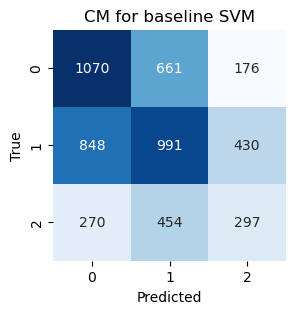

(SVC(kernel='sigmoid', random_state=66),
 0.45372330190494514,
 4.440092086791992)

In [6]:
try_kernel_svm(X_train, y_train, 'sigmoid')

Acc: 0.5617
Evaluation with cross-validation
Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      1907
           1       0.51      0.72      0.60      2269
           2       0.61      0.05      0.10      1021

    accuracy                           0.56      5197
   macro avg       0.59      0.47      0.45      5197
weighted avg       0.58      0.56      0.52      5197

Baseline Training time: 6.5458


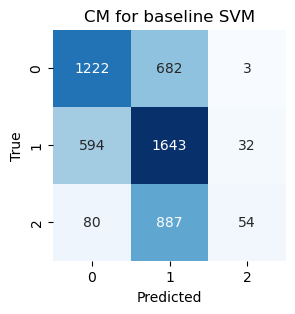

(SVC(kernel='linear', random_state=66), 0.5616701943428901, 6.545801877975464)

In [7]:
try_kernel_svm(X_train, y_train, 'linear')

Acc: 0.5784
Evaluation with cross-validation
Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.53      0.60      1907
           1       0.52      0.76      0.62      2269
           2       0.66      0.27      0.38      1021

    accuracy                           0.58      5197
   macro avg       0.62      0.52      0.53      5197
weighted avg       0.61      0.58      0.56      5197

Baseline Training time: 5.6553


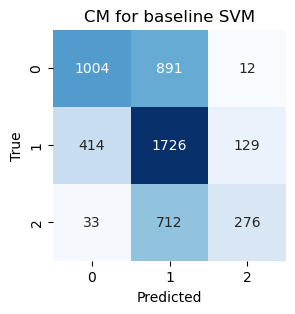

(SVC(kernel='poly', random_state=66), 0.578410621512411, 5.6553099155426025)

In [8]:
try_kernel_svm(X_train, y_train, 'poly')

Acc: 0.4298
Evaluation with cross-validation
Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.19      0.28      1907
           1       0.37      0.36      0.36      2269
           2       0.46      0.69      0.55      2269

    accuracy                           0.43      6445
   macro avg       0.44      0.42      0.40      6445
weighted avg       0.44      0.43      0.41      6445

Baseline Training time: 14.4237


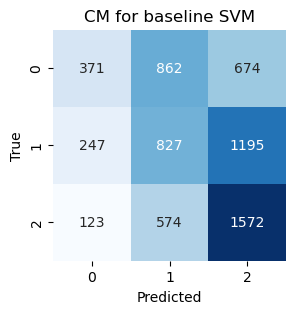

(SVC(random_state=66), 0.42979053529868116, 14.423656940460205)

In [9]:
try_scaling_svm("train.csv", 'normalization')

Acc: 0.4160
Evaluation with cross-validation
Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.24      0.32      1907
           1       0.36      0.35      0.35      2269
           2       0.45      0.63      0.52      2269

    accuracy                           0.42      6445
   macro avg       0.42      0.41      0.40      6445
weighted avg       0.42      0.42      0.40      6445

Baseline Training time: 25.5395


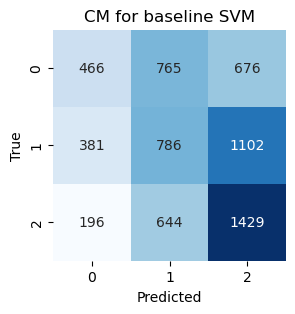

(SVC(random_state=66), 0.41598138091543835, 25.53946089744568)

In [10]:
try_scaling_svm("train.csv", 'polynomial')